In [2]:
!pip install numpy tensorflow keras scikit-learn matplotlib joblib


In [16]:
####Loading all the necessary libraries
import numpy as np
import os
import tensorflow as tf
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers import Adam
from keras.applications import VGG16, ResNet50
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input



In [4]:
# Define a mapping of folder names to class names
class_mapping = {
    'Malignant cases': 0,
    'Bengin cases': 1,
    'Normal cases': 2
}

# Reverse mapping to convert numerical labels back to class names
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

# Function to convert numerical labels back to class names
def numerical_to_classname(label):
    return reverse_class_mapping[label]

# Function to load images from folder
def load_images_from_folder(folder, img_width=224, img_height=224):
    images = []
    labels = []
    class_name = class_mapping.get(os.path.basename(folder), -1)
    for filename in os.listdir(folder):
        img = image.load_img(os.path.join(folder, filename), target_size=(img_width, img_height))
        img = image.img_to_array(img)
        images.append(img)
        labels.append(class_name)
    return np.array(images), np.array(labels)

Step 3: Load and Preparing Images

In [5]:
# Load images and labels, and get class name
def load_dataset(dataset_path):
    images = []
    labels = []
    class_names = []
    for subdir in os.listdir(dataset_path):
        subdir_path = os.path.join(dataset_path, subdir)
        if os.path.isdir(subdir_path):
            img_data, img_labels = load_images_from_folder(subdir_path)
            images.extend(img_data)
            labels.extend(img_labels)
            class_names.append(class_mapping.get(subdir, 'Unknown'))
    return np.array(images), np.array(labels), class_names

# Load images and making labels
dataset_path = r"C:\Users\DELL\Desktop\lung cancer detection\comparing-multimodal-machine-learning-model-to-lung-cancer-classification\dataset" # Dataset root path
images, labels, class_names = load_dataset(dataset_path)

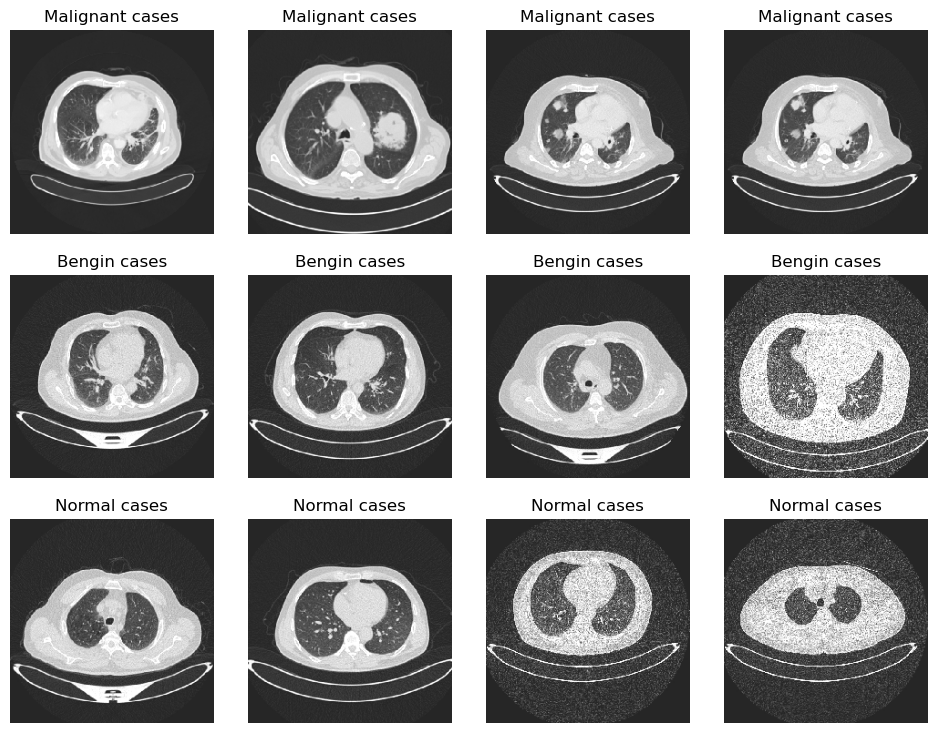

In [6]:
def show_sample_images(images, labels, class_names):
    unique_classes = np.unique(labels)
    num_classes = len(unique_classes)
    fig, axes = plt.subplots(num_classes, 4, figsize=(12, 3*num_classes))  # Adjust the figsize

    for i, class_name in enumerate(unique_classes):
        class_images = images[labels == class_name]
        for j in range(4):
            axes[i, j].imshow(class_images[j].astype('uint8'))
            axes[i, j].set_title(numerical_to_classname(class_name))
            axes[i, j].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.2)  # Adjust the spacing between subplots
    plt.show()

# Usage
show_sample_images(images, labels, class_names)

Step 4: Defining CNN Model Creation Function

In [7]:
def create_cnn_model(input_shape=(224, 224, 3), num_classes=3):
    # Create a Sequential model
    model = Sequential()

    # Add the first convolutional layer with 32 filters, 3x3 kernel size, and ReLU activation
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    # Add max pooling layer to downsample the feature maps
    model.add(MaxPooling2D((2, 2)))

    # Add the second convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # Add max pooling layer to downsample the feature maps
    model.add(MaxPooling2D((2, 2)))

    # Add the third convolutional layer with 128 filters, 3x3 kernel size, and ReLU activation
    model.add(Conv2D(128, (3, 3), activation='relu'))
    # Add max pooling layer to downsample the feature maps
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output from convolutional layers to a 1D array
    model.add(Flatten())

    # Add a fully connected dense layer with 128 units and ReLU activation
    model.add(Dense(128, activation='relu'))
    # Apply dropout regularization to prevent overfitting
    model.add(Dropout(0.5))

    # Add the output layer with softmax activation for multiclass classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with Adam optimizer, sparse categorical cross-entropy loss, and accuracy metric
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

Defining Transfer Learning Models Using VGG16 Functions

In [8]:
# Function to create transfer learning model using VGG16
def create_vgg_model(input_shape=(224, 224, 3), num_classes=3):
    # Load pre-trained VGG16 model with weights from ImageNet
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Set all layers in VGG16 model to non-trainable
    for layer in vgg_model.layers:
        layer.trainable = False
    
    # Create a Sequential model
    model = Sequential()
    
    # Add the pre-trained VGG16 model to the Sequential model
    model.add(vgg_model)
    
    # Flatten the output from VGG16 model
    model.add(Flatten())
    
    # Add a fully connected dense layer with 256 units and ReLU activation
    model.add(Dense(256, activation='relu'))
    
    # Add the output layer with softmax activation for multiclass classification
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model with Adam optimizer, sparse categorical cross-entropy loss, and accuracy metric
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

Defining Transfer Learning Models Using ResNet50 Functions

In [9]:
# Function to create transfer learning model using ResNet50
def create_resnet_model(input_shape=(224, 224, 3), num_classes=3):
    # Load pre-trained ResNet50 model with weights from ImageNet
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Set all layers in ResNet50 model to non-trainable
    for layer in resnet_model.layers:
        layer.trainable = False
    
    # Create a Sequential model
    model = Sequential()
    
    # Add the pre-trained ResNet50 model to the Sequential model
    model.add(resnet_model)
    
    # Flatten the output from ResNet50 model
    model.add(Flatten())
    
    # Add a fully connected dense layer with 256 units and ReLU activation
    model.add(Dense(256, activation='relu'))
    
    # Add the output layer with softmax activation for multiclass classification
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model with Adam optimizer, sparse categorical cross-entropy loss, and accuracy metric
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

Defining Model Training Function

In [10]:
# Function to load data and train model
def train_model(data, model_creator, model_name='', img_width=224, img_height=224, num_epochs=10, batch_size=32):
    images = data['images']
    labels = data['labels']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10, shuffle=True)

    # Create model
    model = model_creator(input_shape=(img_width, img_height, 3))

    # Train model
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

    # Plot graph
    plot_accuracy_loss_side_by_side(history, model_name)

    return model, history

In [11]:
# Function to plot accuracy and loss graphs side by side
def plot_accuracy_loss_side_by_side(history, model_name):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Model Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Model Loss')
    plt.legend()

    plt.show()
    
# Plot graph for Random Forest
def plot_accuracy_rf(train_accuracy, test_accuracy):
    plt.figure(figsize=(8, 6))
    plt.bar(['Train', 'Test'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
    plt.ylim([0, 1])
    plt.ylabel('Accuracy')
    plt.title('Random Forest - Train and Test Accuracy')
    plt.show()

Defining Function for Training Random Forest Model

In [12]:
# Function to train Random Forest model
def train_random_forest(X_train, y_train):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    return rf

EXECUTING MAIN CODE OF ALL THE MODELS TO TRAIN MODELS TO DETECT THE LUNG CANCER ACCURATELY

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.4983 - loss: 132.5106 - val_accuracy: 0.9227 - val_loss: 0.3434
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8964 - loss: 0.3581 - val_accuracy: 0.9727 - val_loss: 0.1271
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9593 - loss: 0.1499 - val_accuracy: 0.9591 - val_loss: 0.1766
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9572 - loss: 0.1362 - val_accuracy: 0.9909 - val_loss: 0.0438
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9808 - loss: 0.0660 - val_accuracy: 0.9864 - val_loss: 0.0393
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9710 - loss: 0.1035 - val_accuracy: 0.9818 - val_loss: 0.0397
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9862 - loss: 0.0483 - val_accuracy: 0.9909 - val_loss: 0.0252
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9849 - loss: 0.0482 - val_accuracy: 0.9909 - val_los

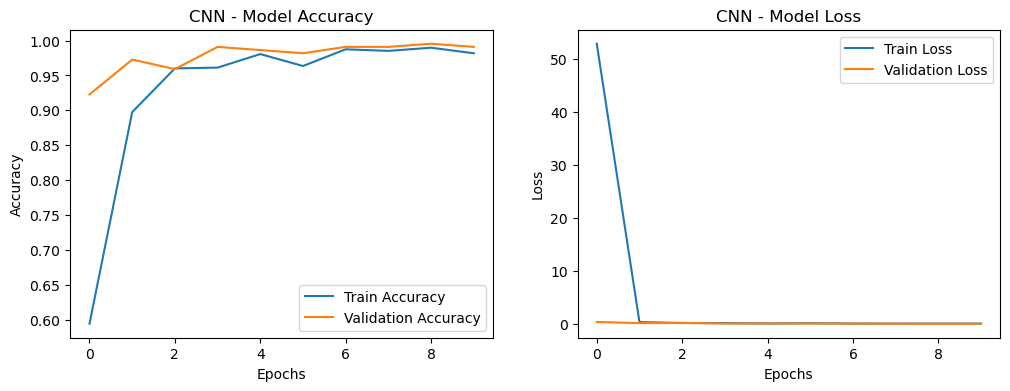

In [13]:
# Train CNN model and get its history
cnn_model, cnn_history = train_model(
    {'images': images, 'labels': labels},
    create_cnn_model,
    'CNN'
)

# Save CNN model
cnn_model.save('./models/cnn_model.h5')

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 226s 8s/step - accuracy: 0.6495 - loss: 10.6634 - val_accuracy: 0.9045 - val_loss: 0.9379
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 224s 8s/step - accuracy: 0.9225 - loss: 0.6036 - val_accuracy: 0.9409 - val_loss: 0.3928
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 219s 8s/step - accuracy: 0.9831 - loss: 0.1261 - val_accuracy: 0.9818 - val_loss: 0.0579
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 218s 8s/step - accuracy: 0.9979 - loss: 0.0053 - val_accuracy: 0.9864 - val_loss: 0.0418
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 219s 8s/step - accuracy: 0.9983 - loss: 0.0097 - val_accuracy: 0.9909 - val_loss: 0.0320
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 223s 8s/step - accuracy: 0.9967 - loss: 0.0073 - val_accuracy: 0.9909 - val_loss: 0.0222
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 219s 8s/step - accuracy: 0.9994 - loss: 0.0015 - val_accuracy: 0.9864 - val_loss: 0.0324
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 217s 8s/step - accuracy: 1.0000 - loss: 5.6276e-04 - val_accuracy: 0.990

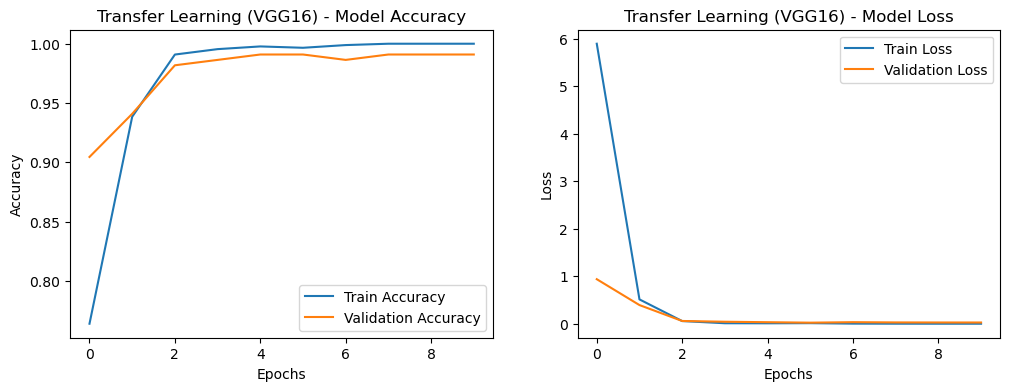

In [17]:
# Train Transfer Learning (VGG16) model and get its history
vgg_model, vgg_history = train_model(
    {'images': images, 'labels': labels},
    create_vgg_model,
    'Transfer Learning (VGG16)',
    img_width = 224,
    img_height = 224
)

# Save Transfer Learning (VGG16) model
vgg_model.save('./models/vgg_model.h5')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 149s 2us/step
Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.6854 - loss: 3.6808 - val_accuracy: 0.9545 - val_loss: 0.1403
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9580 - loss: 0.1216 - val_accuracy: 0.9727 - val_loss: 0.0799
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9960 - loss: 0.0347 - val_accuracy: 0.9773 - val_loss: 0.0512
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.9818 - val_loss: 0.0372
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.9999 - loss: 0.0036 - val_accuracy: 0.9773 - val_loss: 0.0395
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9864 - val_loss: 0.0296
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9818 - val_loss: 0.0276
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 1.

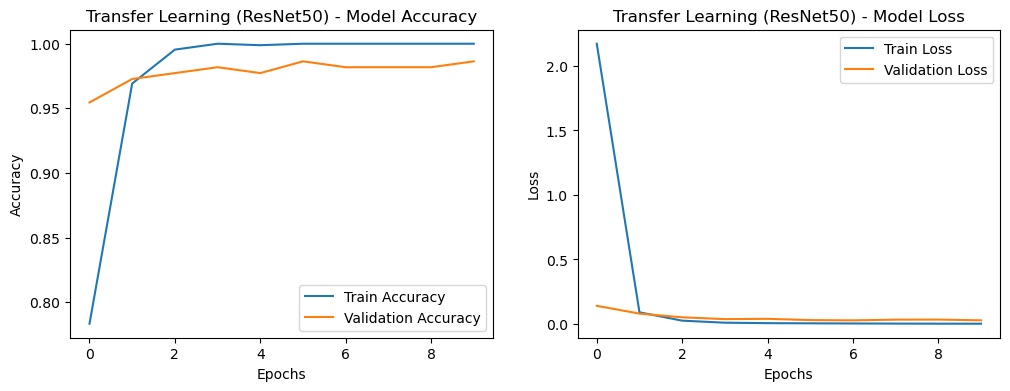

In [18]:
# Train Transfer Learning (ResNet50) model and get its history
resnet_model, resnet_history = train_model(
    {'images': images, 'labels': labels},
    create_resnet_model,
    'Transfer Learning (ResNet50)',
    img_width = 224,
    img_height = 224
)

# Save Transfer Learning (ResNet50) model
resnet_model.save('./models/resnet_model.h5')

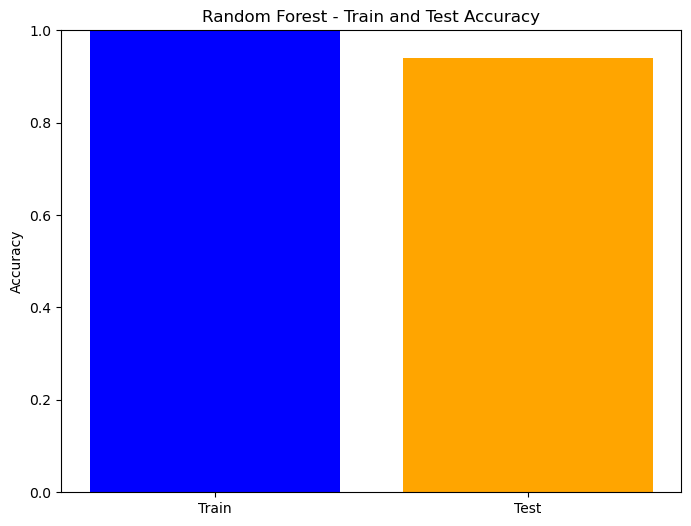

['./models/rf_model.joblib']

In [19]:
# Train Random Forest model
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)
rf_model = train_random_forest(
    X_train,
    y_train
)

# Evaluate Random Forest model
rf_predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

# Calculate train accuracy for RF
rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train.reshape(X_train.shape[0], -1)))

# Calculate test accuracy for RF
rf_test_accuracy = accuracy_score(y_test, rf_predictions)

# Plot train and test accuracies side by side for RF
plot_accuracy_rf(rf_train_accuracy, rf_test_accuracy)

# Save Random Forest model
joblib.dump(rf_model, './models/rf_model.joblib')

In [20]:
# Create a table for comparison
import pandas as pd
models_data = {
    'Model': ['CNN', 'Transfer Learning (VGG16)', 'Transfer Learning (ResNet50)', 'Random Forest'],
    'Accuracy': [cnn_history.history['val_accuracy'][-1], vgg_history.history['val_accuracy'][-1], resnet_history.history['val_accuracy'][-1], rf_test_accuracy],
}
df = pd.DataFrame(models_data)

# Find index of highest accuracy
max_index = df['Accuracy'].idxmax()

# Highlight highest accuracy
styled_df = df.style.highlight_max(subset=['Accuracy'], color='lightgreen', axis=0)

# Display styled DataFrame
styled_df

,Model,Accuracy
0,CNN,0.990909
1,Transfer Learning (VGG16),0.990909
2,Transfer Learning (ResNet50),0.986364
3,Random Forest,0.940909


In [21]:
def predict_class_from_sample_image(sample_image_path, cnn_model, transfer_learning_model, resnet_model, rf_model):
    # Load and preprocess the sample image
    img = image.load_img(sample_image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Predict using CNN model
    cnn_prediction = cnn_model.predict(img)
    cnn_class = np.argmax(cnn_prediction)
    cnn_accuracy = cnn_prediction[0][cnn_class]  # Probability of the predicted class

    # Predict using Transfer Learning (VGG16) model
    vgg_prediction = transfer_learning_model.predict(img)
    vgg_class = np.argmax(vgg_prediction)
    vgg_accuracy = vgg_prediction[0][vgg_class]  # Probability of the predicted class

    # Predict using Transfer Learning (ResNet50) model
    resnet_prediction = resnet_model.predict(img)
    resnet_class = np.argmax(resnet_prediction)
    resnet_accuracy = resnet_prediction[0][resnet_class]  # Probability of the predicted class

    # Predict using Random Forest model
    rf_prediction = rf_model.predict(img.reshape(1, -1))
    rf_class = rf_prediction[0]
    rf_accuracy = max(rf_model.predict_proba(img.reshape(1, -1))[0])  # Maximum probability across all classes

    # Return predictions with accuracy scores
    return {
        'CNN': {'class': numerical_to_classname(cnn_class), 'accuracy': cnn_accuracy},
        'Transfer Learning (VGG16)': {'class': numerical_to_classname(vgg_class), 'accuracy': vgg_accuracy},
        'Transfer Learning (ResNet50)': {'class': numerical_to_classname(resnet_class), 'accuracy': resnet_accuracy},
        'Random Forest': {'class': numerical_to_classname(rf_class), 'accuracy': rf_accuracy}
    }

CHECKING ACCURACY OF ALL MODELS WITH MALIGNANT CASE DATA

In [22]:
# Load the models
cnn_model = tf.keras.models.load_model('./models/cnn_model.h5')
vgg_model = tf.keras.models.load_model('./models/vgg_model.h5')
resnet_model = tf.keras.models.load_model('./models/resnet_model.h5')
rf_model = joblib.load('./models/rf_model.joblib')


sample_image_path = './dataset/Malignant cases/Malignant case (100).jpg'
predictions = predict_class_from_sample_image(sample_image_path, cnn_model, vgg_model, resnet_model, rf_model)

# Create a DataFrame from the dictionary
result = pd.DataFrame([(model, result['class'], result['accuracy']) for model, result in predictions.items()], columns=['Model', 'Predicted Class', 'Accuracy'])
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


,Model,Predicred Class,Accuracy
0,CNN,Malignant cases,0.999957
1,Transfer Learning (VGG16),Malignant cases,1.000000
2,Transfer Learning (ResNet50),Malignant cases,1.000000
3,Random Forest,Malignant cases,0.970000


Testing the x-ray data of patient to detect the lung cancer from Resnet_model which given high accuracy 

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
🩺 Prediction: Healthy Lung
Confidence Score: 0.00


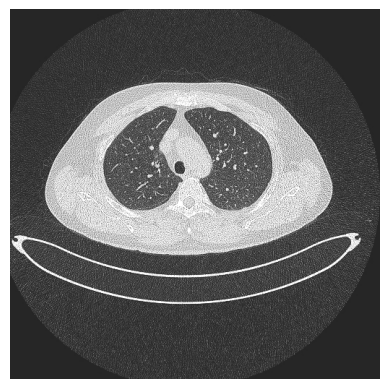

In [23]:
# 📥 Load the trained ResNet50 model
resnet_model = tf.keras.models.load_model('./models/resnet_model.h5')

# 📷 Path to your new X-ray image
image_path = r"C:\Users\DELL\Desktop\lung cancer detection\comparing-multimodal-machine-learning-model-to-lung-cancer-classification\dataset\Normal cases\Normal case (104).jpg"  # <-- Replace with your file

# 🧼 Preprocess the image
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = preprocess_input(img_array)  # ResNet-specific
img_array = np.expand_dims(img_array, axis=0)  # Batch dimension

# 🔮 Predict
prediction = resnet_model.predict(img_array)[0][0]

# 📊 Show Result
plt.imshow(load_img(image_path), cmap='gray')
plt.axis('off')
print("🩺 Prediction:", "Lung Cancer Detected" if prediction > 0.5 else "Healthy Lung")
print(f"Confidence Score: {prediction:.2f}")


Testing the x-ray data of patient to detect the lung cancer from three highly accurated models


In [25]:

# 🔁 Common preprocessing function
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# 📍 Path to image
image_path = r"C:\Users\DELL\Desktop\lung cancer detection\comparing-multimodal-machine-learning-model-to-lung-cancer-classification\dataset\Normal cases\Normal case (104).jpg"  # Replace with your image
processed_image = preprocess_image(image_path)

# 🔄 Load models
vgg_model = tf.keras.models.load_model('./models/vgg_model.h5')
resnet_model = tf.keras.models.load_model('./models/resnet_model.h5')
rf_model = joblib.load('./models/rf_model.joblib')

# 📈 Predict using each model
models = {
    "VGG16 (Transfer Learning)": vgg_model.predict(processed_image)[0][0],
    "ResNet50 (Transfer Learning)": resnet_model.predict(processed_image)[0][0],
    "Random Forest": rf_model.predict([processed_image[0].flatten()])[0]
}

# 💬 Human-style results
def get_message(pred, is_rf=False):
    if (pred > 0.5 and not is_rf) or (pred == 1 and is_rf):
        return "🩺 Lung Cancer Detected - Early detection saves lives. You're not alone. 💪"
    else:
        return "✅ Healthy Lungs - Keep breathing easy and living well! 🌿"

# 📋 Show results
print("🔍 Lung X-Ray Analysis Results:\n")
for name, pred in models.items():
    is_rf = (name == "Random Forest")
    print(f"🔹 {name}: {get_message(pred, is_rf)}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
🔍 Lung X-Ray Analysis Results:

🔹 VGG16 (Transfer Learning): ✅ Healthy Lungs - Keep breathing easy and living well! 🌿
🔹 ResNet50 (Transfer Learning): ✅ Healthy Lungs - Keep breathing easy and living well! 🌿
🔹 Random Forest: ✅ Healthy Lungs - Keep breathing easy and living well! 🌿
